***Create a synthetic dataset for two particles in a harmonic potential trap, with a Coulomb potential between the two.***

Here we have two particles in 1D. Note the fixed points where the Coulomb repulsion and harmonic potential cancel each other out.

Since the $|q_0-q_1|<.20$ region creates numerical instability as the values for $|\ddot{q}|$ become very large and run into rounding errors, I am discarding any points that fall in this region. 

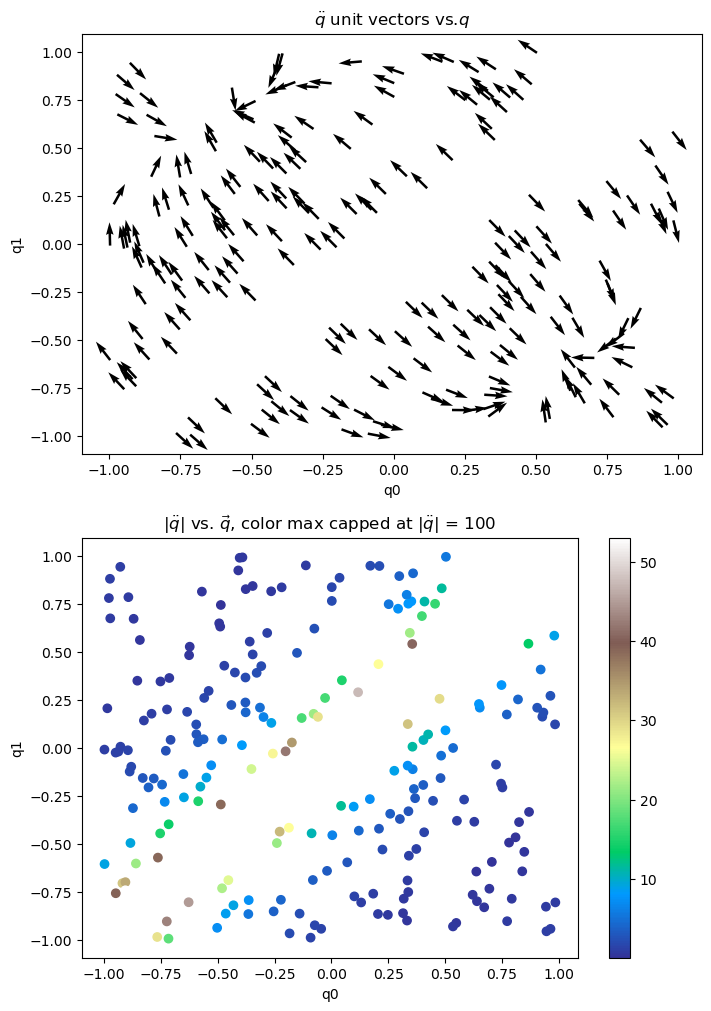

In [13]:
###################
# import statements

import numpy as np
import matplotlib.pyplot as plt
import tqdm
from torch.func import jacfwd, jacrev, vmap
import time
import torch
from torch import tensor, sum, log, max

###############
# problem setup

m = torch.tensor([1],dtype=torch.float64)
k = torch.tensor([1],dtype=torch.float64)
alpha = torch.tensor([1],dtype=torch.float64) #charge0*charge1

n_points = 250
#q0_min = .6298
#q0_max = .6301
#q1_min = -.6301
#q1_max = -.6298

q0_min = -1
q0_max = 1
q1_min = -1
q1_max = 1

dist_threshold = 0.15
qdot_min = -1
qdot_max = 1

######################
# function definitions

def L(qv,qdotv,m,k,alpha): #including Coulomb potential
    return sum(0.5*m*qdotv**2) - sum(0.5*k*qv**2) - alpha*( 1/ (qv[0]-qv[1])**2 )**.5

def QDD(Q,QD,m,k,alpha):
    g_q2 = jacrev(L,argnums=0)(Q,QD,m,k,alpha)
    g_qdot2 = jacrev(L,argnums=1)(Q,QD,m,k,alpha)
    
    g_q_qdot2 = jacrev(jacrev(L,argnums=1),argnums=0)(Q,QD,m,k,alpha)
    g_qdot_q2 = jacrev(jacrev(L,argnums=0),argnums=1)(Q,QD,m,k,alpha)
    g_qdot_qdot2 = jacrev(jacrev(L,argnums=1),argnums=1)(Q,QD,m,k,alpha)
    D = torch.linalg.pinv(g_qdot_qdot2)
    #print(g_q_qdot2@QD.T)
    #print(D@(g_q2 - g_q_qdot2@QD.T).T)
    return (D@(g_q2 - g_q_qdot2@QD.T).T).reshape(Q.shape)

def QDD_true(Q,QD,m,k,alpha): #for testing if output is as expected for alpha=0
    QDD = -k/m*Q
    return QDD

QDDv = vmap(QDD,in_dims=(0,0,None,None,None))


q0_sampling = (q0_max - q0_min)*(torch.rand(n_points)) + q0_min
q1_sampling = (q1_max - q1_min)*(torch.rand(n_points)) + q1_min
qdot_sampling = (qdot_max - qdot_min)*(torch.rand([2,n_points])) + qdot_min

Q0 = q0_sampling
Q1 = q1_sampling
QD0 = qdot_sampling[0,:]
QD1 = qdot_sampling[1,:]

reject_Q = abs(Q0-Q1) >= dist_threshold

Q0 = Q0[reject_Q]
Q1 = Q1[reject_Q]
QD0 = QD0[reject_Q]
QD1 = QD1[reject_Q]

n_points = Q0.size()[0]

im = 0*torch.zeros([n_points,n_points])
#print(im.shape)



Qv = torch.zeros(n_points,2)
Qv[:,0] = Q0
Qv[:,1] = Q1

QDv = torch.zeros(n_points,2)
QDv[:,0] = QD0
QDv[:,1] = QD1

out = QDDv(Qv,QDv,m,k,alpha)
outmag = (out[:,0]**2 + out[:,1]**2)**.5
#print(out)

#####
# plotting

quiver_points = 500 #define how many arrows to quiver plot
if quiver_points > n_points: #if specified value greater than number of points analyzed
    quiver_points = n_points #set quiver_points to n_points
fig,axs = plt.subplots(2,1,figsize=(8,12))
axs[0].quiver(Qv[:quiver_points,0],Qv[:quiver_points,1],out[:quiver_points,0]/outmag[:quiver_points],out[:quiver_points,1]/outmag[:quiver_points])
axs[0].set_xlabel('q0')
axs[0].set_ylabel('q1')
axs[0].set_title(r'$\ddot{q}$ unit vectors vs.$q$')

cmax = 100
scatter = axs[1].scatter(Qv[:,0],Qv[:,1],c=np.min([outmag , cmax*torch.ones(n_points)],axis=0),cmap='terrain')
plt.colorbar(scatter,ax=axs[1])
axs[1].set_xlabel('q0')
axs[1].set_ylabel('q1')
axs[1].set_title(r'$|\ddot{q}|$ vs. $\vec{q}$, color max capped at $|\ddot{q}|$ = ' + f'{cmax}')


plt.show()

***Given this synthetic dataset, fit a polynomial Lagrangian:***

Let $d_i$ be the $i$th point in the synthetic dataset, and $\mathcal{P}$ be the tensor of parameters.

The Lagrangian is then
$$
\mathcal{L} = \frac{1}{2}\dot{q}^2 + \frac{1}{2}q^2 + \sum_{i,j}c_{i,j}q_0^i q_1^j
$$




$l = \frac{1}{N}\sum_i^N \Big( \ddot{q}_i(\mathcal{P}) - d_i\Big)^2$




100%|██████████| 50/50 [00:09<00:00,  5.52it/s]


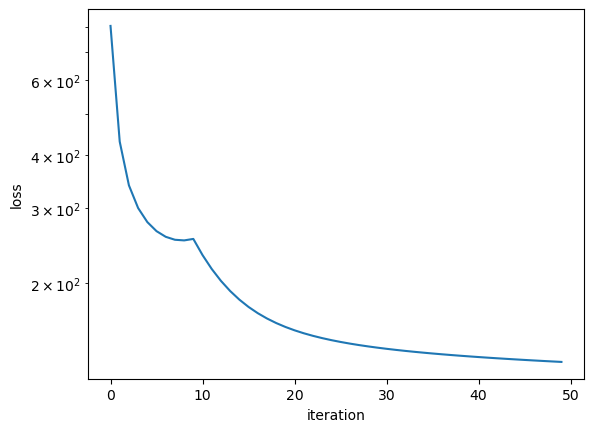

RMS change in parameters after training = 0.0


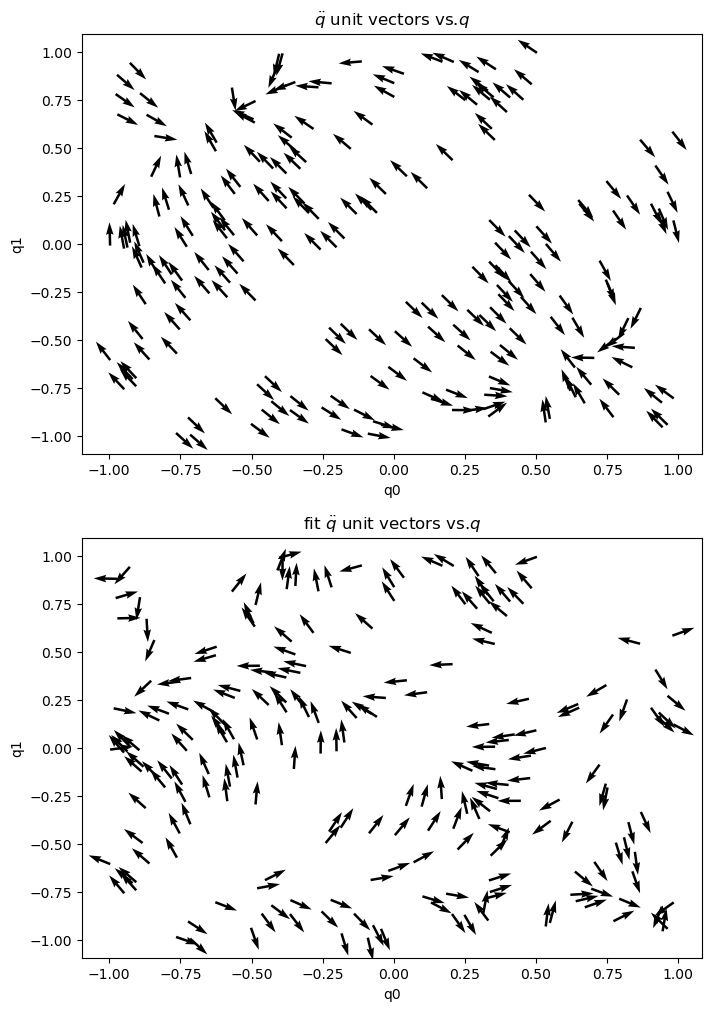

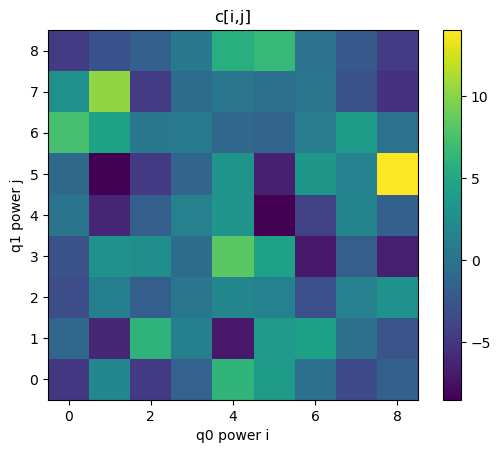

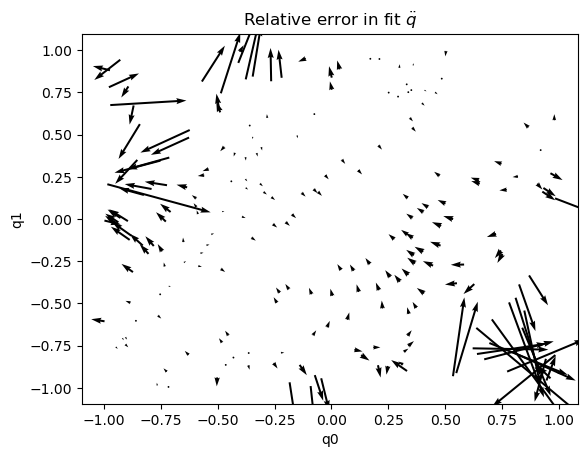

In [21]:
#fixing mass, k = 1 for all particles to simplify the setup
def Lt(qv,qdotv,params): #including Coulomb potential
    s0 = params.size()[0]
    s1 = params.size()[1]
    Lt = 0
    for i in range(s0): 
        for j in range(s1):
            Lt += torch.sum(params[i,j]* (qv[0]**(i)) * (qv[1]**(j)))
    Lt += torch.sum(0.5*qdotv**2) + torch.sum(0.5*k*qv**2)
    return Lt

def QDDt(Q,QD,params):
    g_q2 = jacrev(Lt,argnums=0)(Q,QD,params)
    g_qdot2 = jacrev(Lt,argnums=1)(Q,QD,params)
    
    g_q_qdot2 = jacrev(jacrev(Lt,argnums=1),argnums=0)(Q,QD,params)
    g_qdot_q2 = jacrev(jacrev(Lt,argnums=0),argnums=1)(Q,QD,params)
    g_qdot_qdot2 = jacrev(jacrev(Lt,argnums=1),argnums=1)(Q,QD,params)
    D = torch.linalg.pinv(g_qdot_qdot2)
    #print(g_q_qdot2@QD.T)
    #print(D@(g_q2 - g_q_qdot2@QD.T).T)
    return (D@(g_q2 - g_q_qdot2@QD.T).T).reshape(Q.shape)

QDDtv = vmap(QDDt,in_dims=(0,0,None))

def loss_alt(q,qdot,params,dataset):
    test_qdd = QDDtv(q,qdot,params)
    return torch.sum(( (test_qdd - dataset) )**2 )/(dataset.size()[0]**1)

grad_param = jacfwd(loss_alt,argnums=2)

#random guess for paramters

n_iterations = 50
learning_rate = 6e-2

loss_history = torch.zeros(n_iterations)

n_trial_init_conditions = 200

n_param_i = 9
n_param_j = 9


param0 = 5*torch.randn((n_param_i,n_param_j)) #randomize initial parameters
#param0[:,0] *= 0 #set all of the q_0^n*q_1^0 powers to zero, allow k value to dominate initially
#param0[0,:] *= 0 #set all of the q_0^0*q_1^n powers to zero
init_loss = loss_alt(Qv,QDv,param0,out)

for i in range(n_trial_init_conditions):   
    paramtest = 5*torch.randn((n_param_i,n_param_j)) #randomize initial parameters
    #paramtest[:,0] *= 0 #set all of the q_0^n*q_1^0 powers to zero, allow k value to dominate initially
    #paramtest[0,:] *= 0 #set all of the q_0^0*q_1^n powers to zero
    loss_test = loss_alt(Qv,QDv,paramtest,out)
    if loss_test < init_loss:
        param0 = paramtest
    
param = param0

increasing_count_threshold = 10 #break loop if the loss increases on >value separate iterations
increasing_count_lr_drop = 0.9 #if loss increases, decrease learning rate by this fraction
increasing_count = 0

working_learning_rate = learning_rate

count = 0
for i in tqdm.trange(n_iterations):
    count += 1
    loss_temp = loss_alt(Qv,QDv,param,out)
    loss_history[i] = loss_temp
    if loss_temp >= loss_history[i-1]:
        increasing_count += 1
        working_learning_rate = working_learning_rate * increasing_count_lr_drop
        if increasing_count > increasing_count_threshold:
            print(f'loss increasing, breaking training loop! at iteration {i}!')
            break
    param.data -= working_learning_rate*grad_param(Qv,QDv,param,out)

qdd_fit = QDDtv(Qv,QDv,param)
qdd_fit_mag = (qdd_fit[:,0]**2 + qdd_fit[:,1]**2)**.5

plt.plot(loss_history)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.yscale('log')
plt.show()

#plt.plot(torch.sqrt(( (out - qdd_fit)**2 ).sum(axis=1)))
#plt.show()


out = QDDv(Qv,QDv,m,k,alpha)
outmag = (out[:,0]**2 + out[:,1]**2)**.5


print(f'RMS change in parameters after training = {torch.sqrt(torch.mean((param-param0)**2))}')

#####
# plotting

quiver_points = 500 #define how many arrows to quiver plot
if quiver_points > n_points: #if specified value greater than number of points analyzed
    quiver_points = n_points #set quiver_points to n_points
fig,axs = plt.subplots(2,1,figsize=(8,12))
axs[0].quiver(Qv[:quiver_points,0],Qv[:quiver_points,1],out[:quiver_points,0]/outmag[:quiver_points],out[:quiver_points,1]/outmag[:quiver_points])
axs[0].set_xlabel('q0')
axs[0].set_ylabel('q1')
axs[0].set_title(r'$\ddot{q}$ unit vectors vs.$q$')

axs[1].quiver(Qv[:quiver_points,0],Qv[:quiver_points,1],qdd_fit[:quiver_points,0]/qdd_fit_mag[:quiver_points],qdd_fit[:quiver_points,1]/qdd_fit_mag[:quiver_points])
axs[1].set_xlabel('q0')
axs[1].set_ylabel('q1')
axs[1].set_title(r'fit $\ddot{q}$ unit vectors vs.$q$')


plt.show()

#plot parameter values
plt.imshow((param),extent=[-0.5,n_param_i-0.5,-0.5,n_param_j-0.5],origin='lower')
plt.colorbar()
plt.xlabel('q0 power i')
plt.ylabel('q1 power j')
plt.title('c[i,j]')
plt.show()

#plot error
plt.quiver(Qv[:quiver_points,0],Qv[:quiver_points,1],(qdd_fit[:quiver_points,0]-out[:quiver_points,0])/outmag[:quiver_points],(qdd_fit[:quiver_points,1]-out[:quiver_points,1])/outmag[:quiver_points])
plt.xlabel('q0')
plt.ylabel('q1')
plt.title(r'Relative error in fit $\ddot{q}$')
plt.show()


RMS change in parameters after training = 0.0


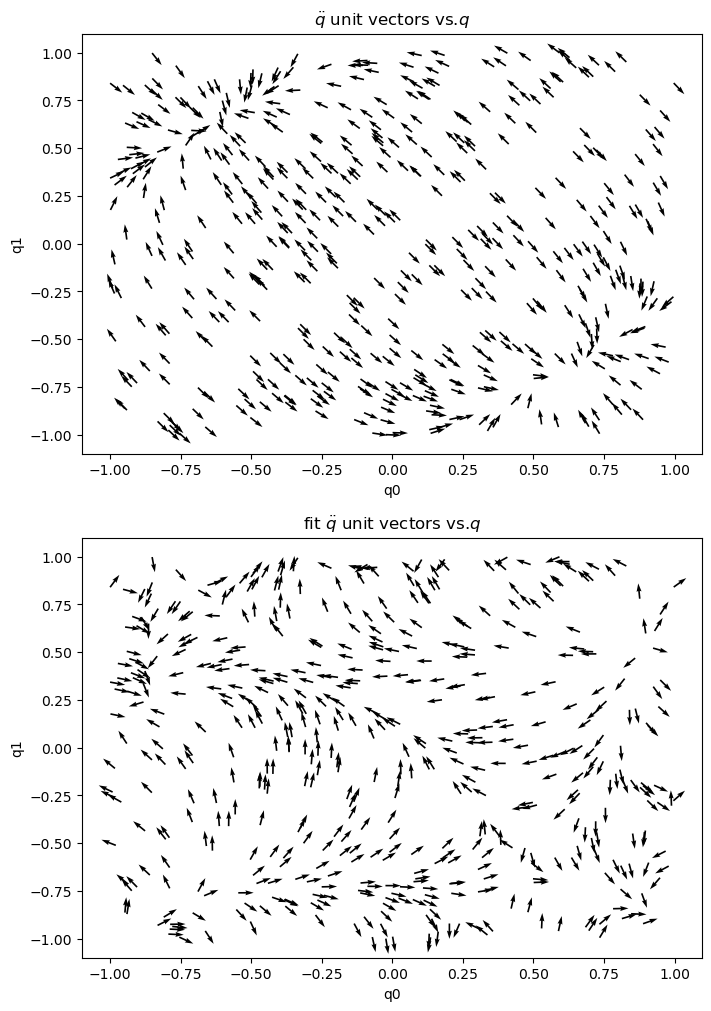

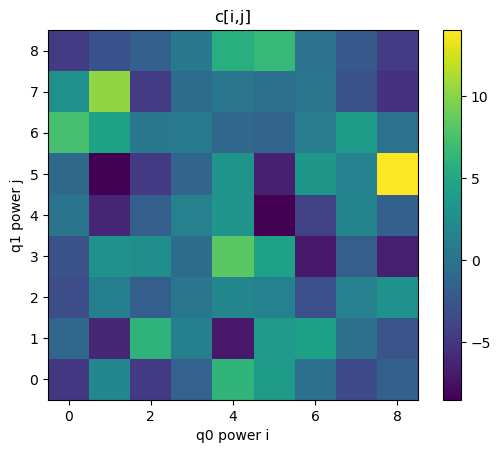

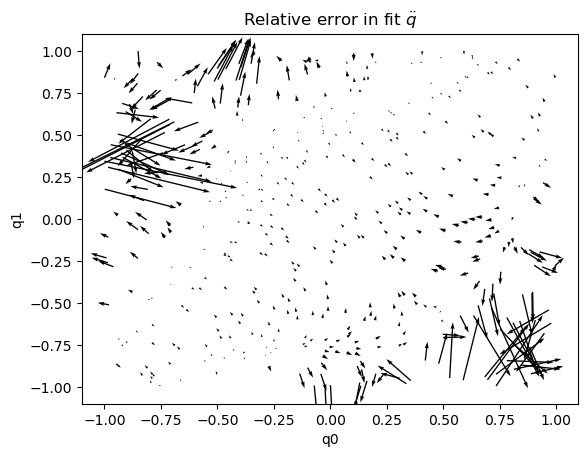

In [23]:
#plot fitted Lagrangian over a larger sampling window:

n_points = 2500
q0_min = -1
q0_max = 1
q1_min = -1
q1_max = 1
dist_threshold = 0.05
qdot_min = -1
qdot_max = 1

q0_sampling = (q0_max - q0_min)*(torch.rand(n_points)) + q0_min
q1_sampling = (q1_max - q1_min)*(torch.rand(n_points)) + q1_min
qdot_sampling = (qdot_max - qdot_min)*(torch.rand([2,n_points])) + qdot_min

Q0 = q0_sampling
Q1 = q1_sampling
QD0 = qdot_sampling[0,:]
QD1 = qdot_sampling[1,:]

reject_Q = abs(Q0-Q1) >= dist_threshold

Q0 = Q0[reject_Q]
Q1 = Q1[reject_Q]
QD0 = QD0[reject_Q]
QD1 = QD1[reject_Q]

n_points = Q0.size()[0]

im = 0*torch.zeros([n_points,n_points])
#print(im.shape)



Qvs = torch.zeros(n_points,2)
Qvs[:,0] = Q0
Qvs[:,1] = Q1

QDvs = torch.zeros(n_points,2)
QDvs[:,0] = QD0
QDvs[:,1] = QD1

outs = QDDv(Qvs,QDvs,m,k,alpha)
outmags = (outs[:,0]**2 + outs[:,1]**2)**.5

qdd_fits = QDDtv(Qvs,QDvs,param) #fitted Lagrangian over test region
qdd_fit_mags = (qdd_fits[:,0]**2 + qdd_fits[:,1]**2)**.5

out = QDDv(Qv,QDv,m,k,alpha) #original Lagrangian over test region
outmag = (out[:,0]**2 + out[:,1]**2)**.5


print(f'RMS change in parameters after training = {torch.sqrt(torch.mean((param-param0)**2))}')

#####
# plotting

quiver_points = 500 #define how many arrows to quiver plot
if quiver_points > n_points: #if specified value greater than number of points analyzed
    quiver_points = n_points #set quiver_points to n_points
fig,axs = plt.subplots(2,1,figsize=(8,12))
axs[0].quiver(Qvs[:quiver_points,0],Qvs[:quiver_points,1],outs[:quiver_points,0]/outmags[:quiver_points],outs[:quiver_points,1]/outmags[:quiver_points])
axs[0].set_xlabel('q0')
axs[0].set_ylabel('q1')
axs[0].set_title(r'$\ddot{q}$ unit vectors vs.$q$')

axs[1].quiver(Qvs[:quiver_points,0],Qvs[:quiver_points,1],qdd_fits[:quiver_points,0]/qdd_fit_mags[:quiver_points],qdd_fits[:quiver_points,1]/qdd_fit_mags[:quiver_points])
axs[1].set_xlabel('q0')
axs[1].set_ylabel('q1')
axs[1].set_title(r'fit $\ddot{q}$ unit vectors vs.$q$')


plt.show()

#plot parameter values
plt.imshow((param),extent=[-0.5,n_param_i-0.5,-0.5,n_param_j-0.5],origin='lower')
plt.colorbar()
plt.xlabel('q0 power i')
plt.ylabel('q1 power j')
plt.title('c[i,j]')
plt.show()

#plot error
plt.quiver(Qvs[:quiver_points,0],Qvs[:quiver_points,1],(qdd_fits[:quiver_points,0]-outs[:quiver_points,0])/outmags[:quiver_points],(qdd_fits[:quiver_points,1]-outs[:quiver_points,1])/outmags[:quiver_points])
plt.xlabel('q0')
plt.ylabel('q1')
plt.title(r'Relative error in fit $\ddot{q}$')
plt.show()



Plotting functions split out for mid-run breaks:

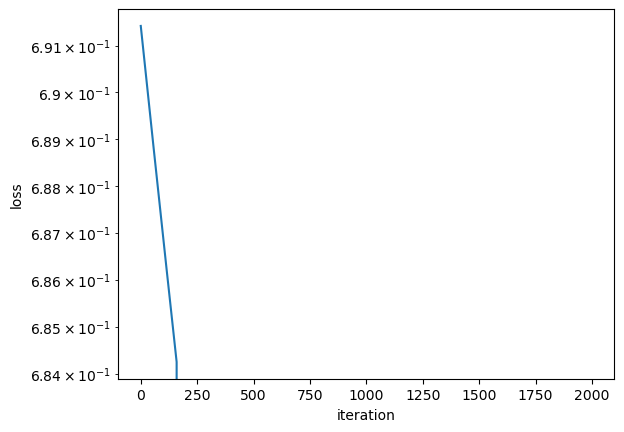

RMS change in parameters after training = 0.0


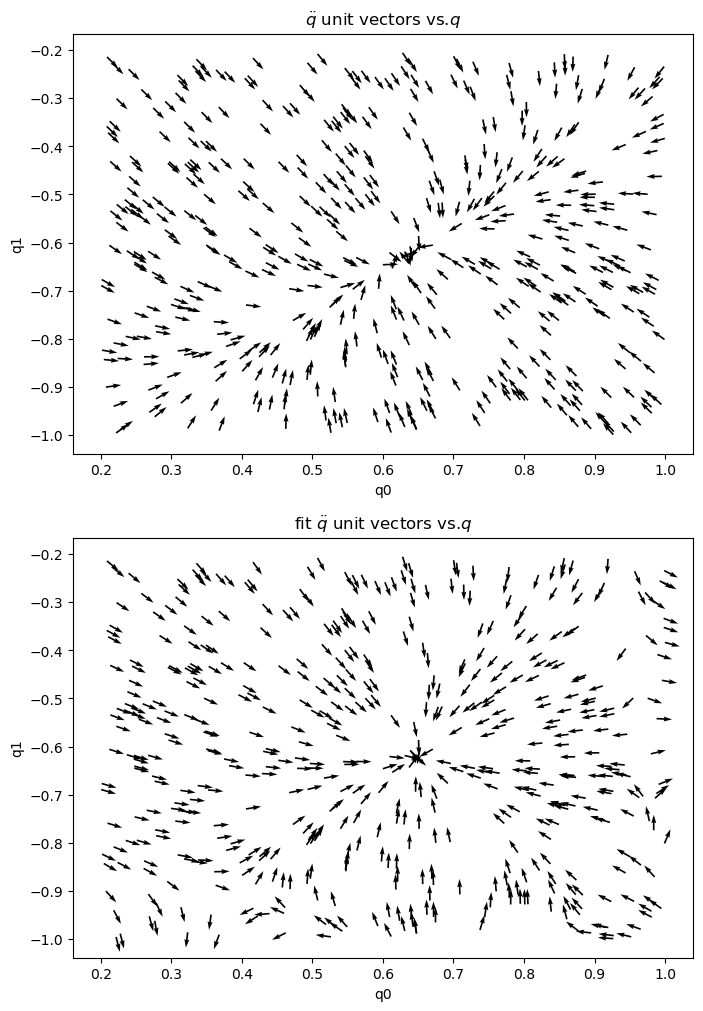

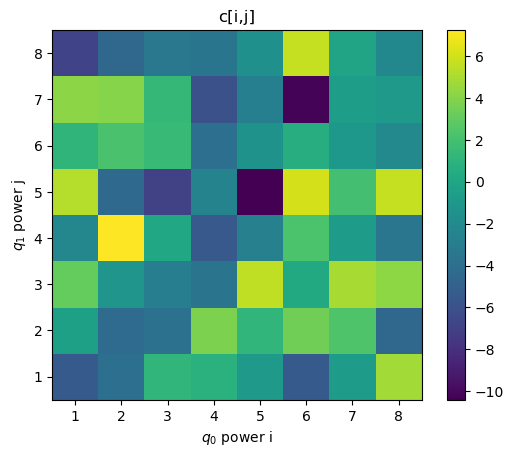

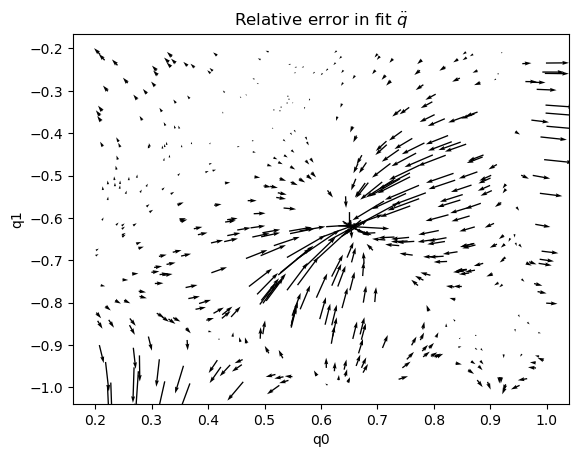

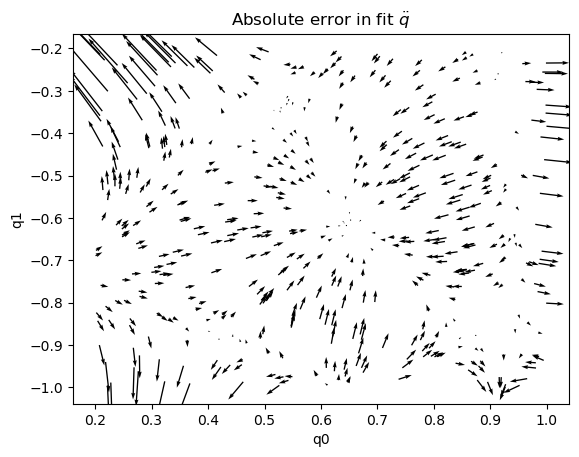

In [392]:
qdd_fit = QDDtv(Qv,QDv,param)
qdd_fit_mag = (qdd_fit[:,0]**2 + qdd_fit[:,1]**2)**.5

plt.plot(loss_history)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.yscale('log')
plt.show()

#plt.plot(torch.sqrt(( (out - qdd_fit)**2 ).sum(axis=1)))
#plt.show()


out = QDDv(Qv,QDv,m,k,alpha)
outmag = (out[:,0]**2 + out[:,1]**2)**.5


print(f'RMS change in parameters after training = {torch.sqrt(torch.mean((param-param0)**2))}')

#####
# plotting

quiver_points = 500 #define how many arrows to quiver plot
if quiver_points > n_points: #if specified value greater than number of points analyzed
    quiver_points = n_points #set quiver_points to n_points
fig,axs = plt.subplots(2,1,figsize=(8,12))
axs[0].quiver(Qv[:quiver_points,0],Qv[:quiver_points,1],out[:quiver_points,0]/outmag[:quiver_points],out[:quiver_points,1]/outmag[:quiver_points])
axs[0].set_xlabel('q0')
axs[0].set_ylabel('q1')
axs[0].set_title(r'$\ddot{q}$ unit vectors vs.$q$')

axs[1].quiver(Qv[:quiver_points,0],Qv[:quiver_points,1],qdd_fit[:quiver_points,0]/qdd_fit_mag[:quiver_points],qdd_fit[:quiver_points,1]/qdd_fit_mag[:quiver_points])
axs[1].set_xlabel('q0')
axs[1].set_ylabel('q1')
axs[1].set_title(r'fit $\ddot{q}$ unit vectors vs.$q$')


plt.show()

#plot parameter values
plt.imshow((param),extent=[0.5,n_param_i+0.5,0.5,n_param_j+0.5],origin='lower')
plt.colorbar()
plt.xlabel(r'$q_0$ power i')
plt.ylabel(r'$q_1$ power j')
plt.title('c[i,j]')
plt.show()

#plot error
plt.quiver(Qv[:quiver_points,0],Qv[:quiver_points,1],(qdd_fit[:quiver_points,0]-out[:quiver_points,0])/outmag[:quiver_points],(qdd_fit[:quiver_points,1]-out[:quiver_points,1])/outmag[:quiver_points])
plt.xlabel('q0')
plt.ylabel('q1')
plt.title(r'Relative error in fit $\ddot{q}$')
plt.show()

plt.quiver(Qv[:quiver_points,0],Qv[:quiver_points,1],(qdd_fit[:quiver_points,0]-out[:quiver_points,0]),(qdd_fit[:quiver_points,1]-out[:quiver_points,1]))
plt.xlabel('q0')
plt.ylabel('q1')
plt.title(r'Absolute error in fit $\ddot{q}$')
plt.show()


Repeat training without re-initialization:

100%|██████████| 5500/5500 [19:45<00:00,  4.64it/s]


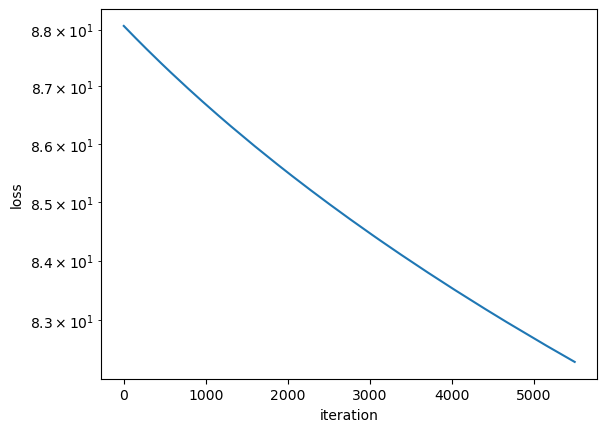

RMS change in parameters after training = 0.0


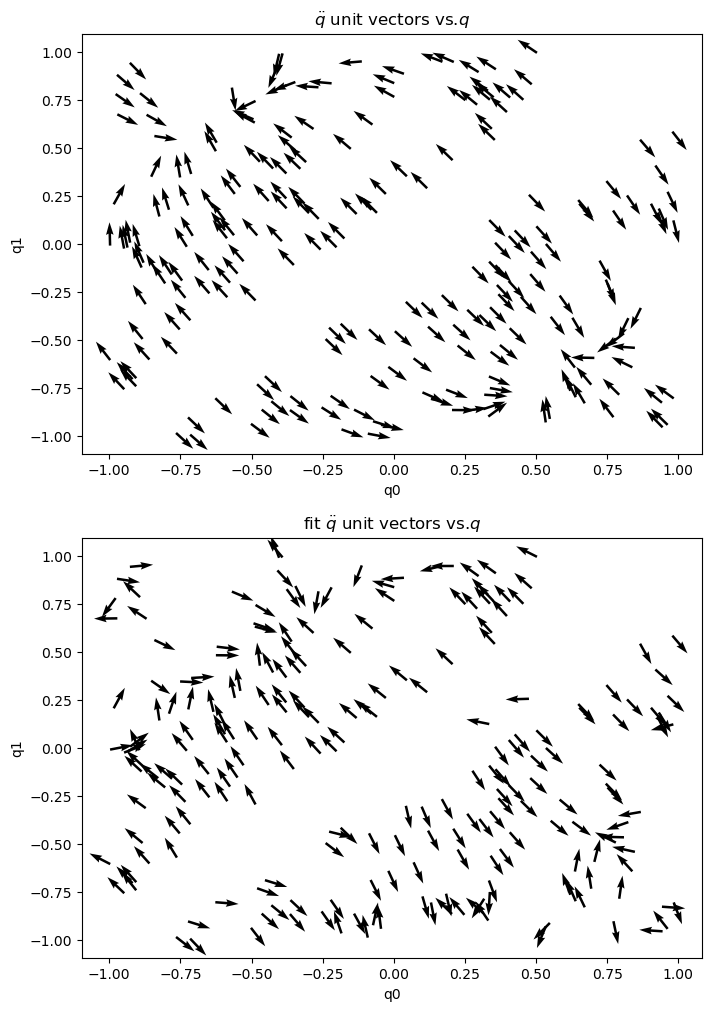

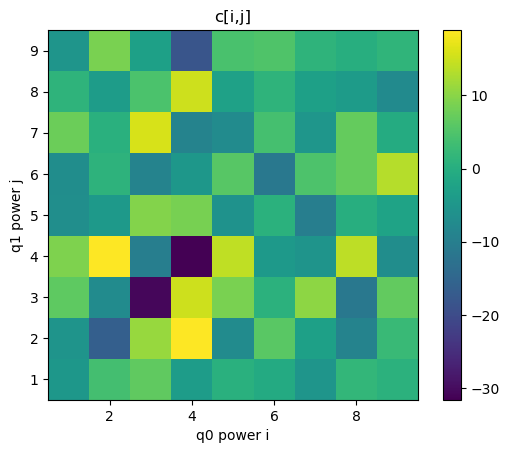

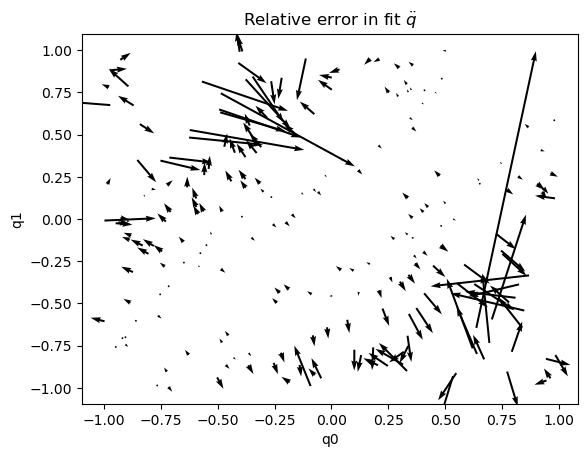

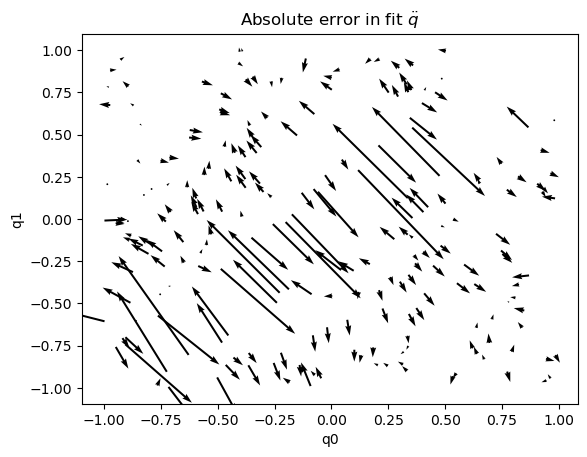

In [36]:
n_iterations = 5500
learning_rate = 4e-2 #uncomment to set a different value here
param_store = param
loss_history = torch.zeros(n_iterations)

increasing_count_threshold = 10 #break loop if the loss increases on >value separate iterations
increasing_count_lr_drop = 0.9 #if loss increases, decrease learning rate by this fraction
increasing_count = 0

working_learning_rate = learning_rate
for i in tqdm.trange(n_iterations):
    count += 1
    loss_temp = loss_alt(Qv,QDv,param,out)
    if loss_temp >= loss_history[i-1]:
        increasing_count += 1
        working_learning_rate = working_learning_rate * increasing_count_lr_drop
        if increasing_count > increasing_count_threshold:
            print(f'loss increasing, breaking training loop! at iteration {i}!')
            break
    loss_history[i] = loss_temp
    param.data -= working_learning_rate*grad_param(Qv,QDv,param,out)

qdd_fit = QDDtv(Qv,QDv,param)
qdd_fit_mag = (qdd_fit[:,0]**2 + qdd_fit[:,1]**2)**.5

plt.plot(loss_history)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.yscale('log')
plt.show()

#plt.plot(torch.sqrt(( (out - qdd_fit)**2 ).sum(axis=1)))
#plt.show()


out = QDDv(Qv,QDv,m,k,alpha)
outmag = (out[:,0]**2 + out[:,1]**2)**.5


print(f'RMS change in parameters after training = {torch.sqrt(torch.mean((param-param0)**2))}')

#####
# plotting

quiver_points = 500 #define how many arrows to quiver plot
if quiver_points > n_points: #if specified value greater than number of points analyzed
    quiver_points = n_points #set quiver_points to n_points
fig,axs = plt.subplots(2,1,figsize=(8,12))
axs[0].quiver(Qv[:quiver_points,0],Qv[:quiver_points,1],out[:quiver_points,0]/outmag[:quiver_points],out[:quiver_points,1]/outmag[:quiver_points])
axs[0].set_xlabel('q0')
axs[0].set_ylabel('q1')
axs[0].set_title(r'$\ddot{q}$ unit vectors vs.$q$')

axs[1].quiver(Qv[:quiver_points,0],Qv[:quiver_points,1],qdd_fit[:quiver_points,0]/qdd_fit_mag[:quiver_points],qdd_fit[:quiver_points,1]/qdd_fit_mag[:quiver_points])
axs[1].set_xlabel('q0')
axs[1].set_ylabel('q1')
axs[1].set_title(r'fit $\ddot{q}$ unit vectors vs.$q$')


plt.show()

#plot parameter values
plt.imshow((param),extent=[0.5,n_param_i+0.5,0.5,n_param_j+0.5],origin='lower')
plt.colorbar()
plt.xlabel('q0 power i')
plt.ylabel('q1 power j')
plt.title('c[i,j]')
plt.show()

#plot error
plt.quiver(Qv[:quiver_points,0],Qv[:quiver_points,1],(qdd_fit[:quiver_points,0]-out[:quiver_points,0])/outmag[:quiver_points],(qdd_fit[:quiver_points,1]-out[:quiver_points,1])/outmag[:quiver_points])
plt.xlabel('q0')
plt.ylabel('q1')
plt.title(r'Relative error in fit $\ddot{q}$')
plt.show()

plt.quiver(Qv[:quiver_points,0],Qv[:quiver_points,1],(qdd_fit[:quiver_points,0]-out[:quiver_points,0]),(qdd_fit[:quiver_points,1]-out[:quiver_points,1]))
plt.xlabel('q0')
plt.ylabel('q1')
plt.title(r'Absolute error in fit $\ddot{q}$')
plt.show()